In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-sep-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-sep-2022/train.csv
/kaggle/input/tabular-playground-series-sep-2022/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV , cross_val_score ,cross_validate


In [3]:
train_data = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2022/train.csv')
test_data = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2022/test.csv')
submission = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2022/sample_submission.csv')


In [4]:
train_data_row, train_data_col = train_data.shape
print('Total rows: ', train_data_row)
print('Total columns: ', train_data_col)

Total rows:  70128
Total columns:  6


In [5]:
train_data.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [6]:
train_data.tail()

,row_id,date,country,store,product,num_sold
70123,70123,2020-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,614
70124,70124,2020-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,215
70125,70125,2020-12-31,Spain,KaggleRama,Kaggle Getting Started,158
70126,70126,2020-12-31,Spain,KaggleRama,Kaggle Recipe Book,135
70127,70127,2020-12-31,Spain,KaggleRama,Kaggle for Kids: One Smart Goose,202


In [7]:
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

Text(0.5, 1.0, 'Product Sales by Store')

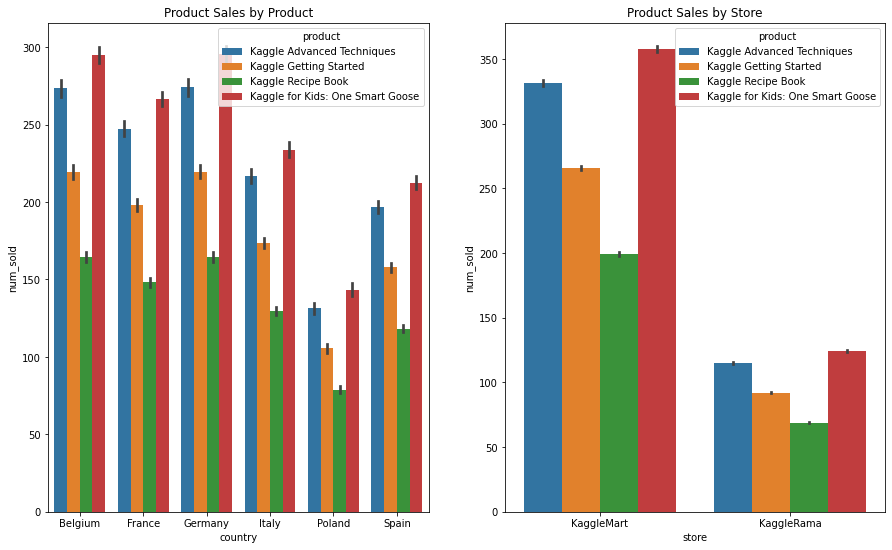

In [8]:
fig = plt.figure(figsize=(15,9))
fig.set_facecolor('white')

ax1 = fig.add_subplot(1, 2, 1)
sns.barplot(data=train_data, x='country', y='num_sold', hue='product')
ax1.set_title('Product Sales by Product')

ax2 = fig.add_subplot(1, 2, 2)
sns.barplot(data=train_data, x='store', y='num_sold', hue='product')
ax2.set_title("Product Sales by Store")

In [9]:
monthly_sales = train_data.groupby(['country', 'store', 'product', pd.Grouper(key='date', freq='MS')])['num_sold'].sum().reset_index()
monthly_sales

,country,store,product,date,num_sold
0,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-01-01,13345
1,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-02-01,12556
2,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-03-01,14137
3,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-04-01,14575
4,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-05-01,14338
...,...,...,...,...,...
2299,Spain,KaggleRama,Kaggle for Kids: One Smart Goose,2020-08-01,4578
2300,Spain,KaggleRama,Kaggle for Kids: One Smart Goose,2020-09-01,4254
2301,Spain,KaggleRama,Kaggle for Kids: One Smart Goose,2020-10-01,4644
2302,Spain,KaggleRama,Kaggle for Kids: One Smart Goose,2020-11-01,4437


In [10]:
def format_date(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayOfYear'] = df['date'].dt.dayofyear
    df['weekday'] = df['date'].dt.weekday
    return df

train_data = format_date(train_data)
test_data = format_date(test_data)

In [11]:
le = LabelEncoder()
cols = ['country', 'store', 'product']
for col in cols:
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.transform(test_data[col])

In [12]:
train_data = train_data.drop(['date', 'row_id'], axis=1)
test_data = test_data.drop(['date', 'row_id'], axis=1)


In [13]:
X = train_data.drop('num_sold', axis=1)
y = train_data['num_sold'] 

In [14]:
lgb = LGBMRegressor(random_state=42, boosting_type='dart')
lr = LinearRegression()

models = [lgb, lr]

In [15]:
def get_scores(cv_scores):
    scores = np.zeros(test_data.shape[0])
    for estimator in cv_scores['estimator']:
        scores += estimator.predict(test_data)
    scores /= len(cv_scores['estimator'])
    return scores

In [16]:
def smape(a, f):
    # Symmetric mean absolute percentage error (SMAPE or sMAPE) is an accuracy measure based on percentage (or relative) errors
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

smape_score = make_scorer(smape, greater_is_better=False)

scalar = StandardScaler()

res = pd.DataFrame()
row_number = 0
results = []
names = []
prob_scores = []

for model in models:
    model_name=model.__class__.__name__
    pipeline = Pipeline([('transformer', scalar), ('estimator', model)])
    print(model_name, 'training')

    cv_results = cross_validate(pipeline, X, y, cv=42, scoring=smape_score, return_train_score=True, return_estimator=True, n_jobs=-1)

    res.loc[row_number,'Model Name'] = model_name
    res.loc[row_number, 'Train Score Mean'] = cv_results['train_score'].mean()
    res.loc[row_number, 'Test Score Mean'] = cv_results['test_score'].mean()
    res.loc[row_number, 'Fit Time Mean'] = cv_results['fit_time'].mean()
    results.append(cv_results)
    names.append(model_name)
    prob_scores.append(get_scores(cv_results))

    row_number+=1

LGBMRegressor training
LinearRegression training


In [17]:
display(res.style.background_gradient())

,Model Name,Train Score Mean,Test Score Mean,Fit Time Mean
0,LGBMRegressor,-11.356153,-11.911337,3.822723
1,LinearRegression,-32.424895,-32.607023,0.047343


In [18]:
scores = np.zeros(test_data.shape[0])
for estimator in cv_results['estimator']:
    scores += estimator.predict(test_data)
    
scores /= len(cv_results['estimator'])

In [19]:
submission["num_sold"] = scores
submission.head()

,row_id,num_sold
0,70128,369.684694
1,70129,370.519003
2,70130,371.353311
3,70131,372.187620
4,70132,181.205075


In [20]:
submission.to_csv("submission.csv", index = False)